In [1]:
import os 
import sys
import glob
import pickle
import numpy as np 
import pyemma as py
import tensorflow as tf
from os.path import join
import keras.backend as K
import sklearn.preprocessing as pre
import keras.callbacks as callbacks

%matplotlib inline 
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('/home/hsidky/Code/hde/')
from hde import HDE
from hde import analysis

In [5]:
%load_ext autoreload
%autoreload 2

In [21]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

In [22]:
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.5
 
# Create a session with the above options specified.
K.tensorflow_backend.set_session(tf.Session(config=config))

## Process features

In [8]:
trj_dir = "/home/hsidky/Data/DESRES-Trajectory_2JOF-0-protein/2JOF-0-protein"

In [9]:
pdb_file = os.path.join(trj_dir, "2JOF-0-protein.pdb")
traj_files = glob.glob(join(trj_dir, '2JOF-0-protein-*.dcd'))
traj_files.sort()

In [10]:
combined_feat = py.coordinates.featurizer(pdb_file)
combined_feat.add_backbone_torsions(cossin=True, periodic=False)
combined_feat.add_sidechain_torsions(cossin=True, which=["chi1"], periodic=False)
combined_feat.add_distances_ca(periodic=False)
combined_data = py.coordinates.load(traj_files, features=combined_feat)

ca_feat = py.coordinates.featurizer(pdb_file)
ca_feat.add_distances_ca(periodic=False)
ca_data = py.coordinates.load(traj_files, features=ca_feat)

In [11]:
combined_scaled = pre.MinMaxScaler(feature_range=(-1, 1)).fit_transform(np.concatenate(combined_data))
ca_scaled = pre.MinMaxScaler(feature_range=(-1, 1)).fit_transform(np.concatenate(ca_data))

## Load HDEs and create MSMs

hde_model files come from `hde_gen_model` script which trains many hde models of a given set of parameters.

In [24]:
hde_full_feat = pickle.load(open('hde-model-scan/hde_model_078.pkl', 'rb'))
hde_ca_feat = pickle.load(open('best_hde_ca_model.pkl', 'rb'))

/home/hsidky/miniconda3/envs/dnets2/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [13]:
tica_combined = py.coordinates.tica(data=combined_data, lag=100, dim=5, kinetic_map=True)
tica_ca = py.coordinates.tica(data=ca_data, lag=100, dim=5, kinetic_map=True)

In [14]:
cluster_combined = py.coordinates.cluster_kmeans(tica_combined.get_output(), k=200, max_iter=50, stride=1, n_jobs=1)
cluster_ca = py.coordinates.cluster_kmeans(tica_ca.get_output(), k=200, max_iter=50, stride=1, n_jobs=1)

In [15]:
msm_combined = py.msm.bayesian_markov_model(cluster_combined.dtrajs, lag=100)
msm_ca = py.msm.bayesian_markov_model(cluster_ca.dtrajs, lag=100)

## Visualization

In [16]:
Y_full = msm_combined.eigenvectors_right()[:,1:][np.concatenate(cluster_combined.dtrajs)]
Y_ca = msm_ca.eigenvectors_right()[:,1:][np.concatenate(cluster_ca.dtrajs)]

In [17]:
tica_viz = py.load('tica_viz.mdl')
tica_viz.dim = 7
W = tica_viz.fit_transform(combined_scaled)

/home/hsidky/miniconda3/envs/dnets2/lib/python3.6/site-packages/pyemma/_base/serialization/pickle_extensions.py:52: UserWarning: BLOSC compression filter unavailable. Your resulting file may be large and not optimal to process.
  warnings.warn('BLOSC compression filter unavailable. '


In [18]:
Y_ca_cat = np.append(Y_ca[:,0].reshape(-1, 1), Y_ca, axis=1)
Y_ca_ts = np.append(msm_ca.timescales()[0],  msm_ca.timescales())

In [26]:
Z_full = hde_full_feat.transform(combined_scaled)
Z_ca = hde_ca_feat.transform(ca_scaled)

In [29]:
plotting_data = [Z_full, Z_ca, Y_full, Y_ca_cat]
plotting_timescales = [hde_full_feat.timescales_, hde_ca_feat.timescales_, msm_combined.timescales(), Y_ca_ts]

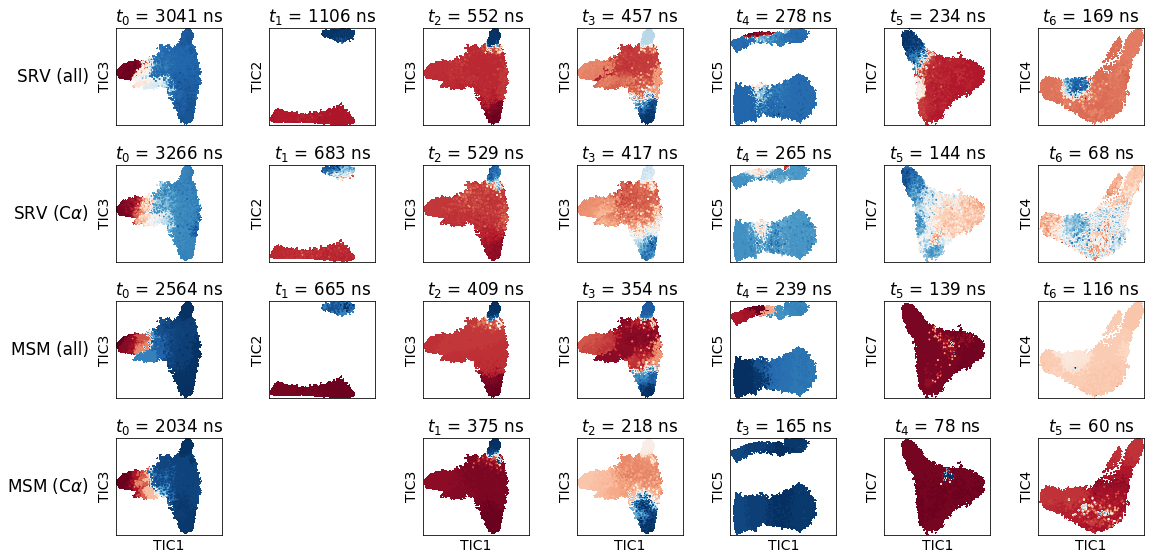

In [37]:
plt.rcParams['font.size'] = 14
fig, axes = plt.subplots(4, 7, figsize=(15, 8), sharex=True)

coords = [[0, 2], [0, 1], [0, 2], [0,2], [0, 4], [5, 6], [2,3]]
signs = [
    [ 1, -1,  1,  1,  1,  1, 1], 
    [-1, -1,  1,  1,  1, -1,-1], 
    [ 1,  1,  1,  1,  1, -1, 1], 
    [ 1,  1, -1, -1, -1, -1, 1]
]
labels = ['SRV (all)', r'SRV (C$\alpha$)', 'MSM (all)', r'MSM (C$\alpha$)']

for i in range(4):
    viz_data = plotting_data[i]
    tt = plotting_timescales[i]
    ss = signs[i]
    for j in range(7): 
        ax = axes[i, j]
        
        if i is 3 and j is 1:
            ax.axis('off')
            continue
        
        py.plots.plot_contour(
            *W[::1, coords[j]].T,
            viz_data[::1, j]*ss[j],
            ax=ax,
            cmap=plt.cm.RdBu,
            cbar=False,
            mask=True
        )
        
        if i is 3 and j > 1:
            ax.set_title(r'$t_{}$ = {:.0f} ns'.format(j-1, tt[j]*0.2))
        else:
            ax.set_title(r'$t_{}$ = {:.0f} ns'.format(j, tt[j]*0.2))

        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.set_ylabel('TIC{}'.format(coords[j][1] + 1))
        if j == 0:
            ax.annotate(labels[i], xy=(0, 0.5), xytext=(-ax.yaxis.labelpad-5,0),                    
            xycoords=ax.yaxis.label, textcoords='offset points',
            size='large', ha='right', va='center')

        if i == 3:
            ax.set_xlabel('TIC{}'.format(coords[i][0] + 1))

plt.tight_layout()
plt.savefig('figures/hde_msm_feature_transform.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Play around with hdes by hand 

In [265]:
hde = HDE(
    ca_feat.dimension(), 
    n_components=7, 
    lag_time=1000, 
    n_epochs=30,
    learning_rate=0.01,
    batch_size=600000, 
    batch_normalization=True)

In [266]:
hde.verbose = True
# hde.learning_rate = 0.005

In [267]:
# ww = np.ones(7)
# ww[0] = 0.1
# hde.weights = ww

In [285]:
hde.learning_rate = 0.001
hde.n_epochs = 10
hde.fit(ca_scaled)

Train on 1043000 samples, validate on 0 samples
Epoch 1/10
1043000/1043000 [==============================] - 5s 5us/step - loss: -3.5792
Epoch 2/10
1043000/1043000 [==============================] - 2s 2us/step - loss: -3.5861
Epoch 3/10
1043000/1043000 [==============================] - 2s 2us/step - loss: -3.5932
Epoch 4/10
1043000/1043000 [==============================] - 2s 2us/step - loss: -3.6014
Epoch 5/10
1043000/1043000 [==============================] - 2s 2us/step - loss: -3.6085
Epoch 6/10
1043000/1043000 [==============================] - 2s 2us/step - loss: -3.6170
Epoch 7/10
1043000/1043000 [==============================] - 2s 2us/step - loss: -3.6246
Epoch 8/10
1043000/1043000 [==============================] - 2s 2us/step - loss: -3.6330
Epoch 9/10
1043000/1043000 [==============================] - 2s 2us/step - loss: -3.6410
Epoch 10/10
1043000/1043000 [==============================] - 2s 2us/step - loss: -3.6495


HDE(activation=None, batch_normalization=True, batch_size=600000,
  callbacks=None, dropout_rate=0, hidden_layer_depth=None,
  hidden_size=None, input_size=153, l2_regularization=0.0, lag_time=1000,
  latent_space_noise=0, learning_rate=0.001, n_components=7, n_epochs=10,
  validation_split=0, verbose=True)

In [284]:
pickle.dump(hde, open('best_hde_ca_model.pkl', 'wb'))

In [188]:
hde.timescales_*0.2

array([3299.24144616,  698.75188917,  535.6547169 ,  421.35811589,
        265.83900475,   67.13647234,   49.79784645])

In [235]:
hde_ca_feat.eigenvalues_ *= 0.995

In [243]:
hde_ca_feat.eigenvalues_[1] -= 0.01